# LAB 4 DATA ANALYSYS

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, MultiHeadAttention, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import re
import string
import keras
import os
from pathlib import Path
from IPython.display import Image, display
from keras.applications import vgg19
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, pipeline

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)


## 1. Завдання щодо машинного перекладу на основі рекурентних мереж

Character-level recurrent sequence-to-sequence model https://keras.io/examples/nlp/lstm_seq2seq/

In [34]:
batch_size = 64 
epochs = 15
latent_dim = 256  # розмірність енкодингу
num_samples = 10000  # скільки семплів брати

Векторизація даних

In [35]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open("ukr.txt", "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
    
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    print(target_text)
    print(input_text)
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
            
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
print(input_characters, target_characters)

	Йди.

Go.
	Вітаю!

Hi.
	Привіт.

Hi.
	Привіт!

Hi.
	Біжіть!

Run!
	Тікайте!

Run!
	Біжи!

Run!
	Оце так!

Wow!
	Клас!

Wow!
	Класно!

Wow!
	Ого!

Wow!
	Ух ти!

Wow!
	Пожежа!

Fire!
	Допоможіть!

Help!
	Стрибайте.

Jump!
	Стрибай.

Jump.
	Стрибайте.

Jump.
	Стій!

Stop!
	Почекай!

Wait!
	Зачекайте.

Wait.
	Починай.

Begin.
	Починайте.

Begin.
	Зроби це.

Do it.
	Робіть це.

Do it.
	Роби це.

Do it.
	Дій.

Do it.
	Дійте.

Do it.
	Вітаю!

Hello!
	Ало!

Hello!
	Добрий день.

Hello!
	Привіт.

Hello!
	Привіт!

Hello!
	Вітаю.

Hello!
	Ало!

Hello.
	Привіт.

Hello.
	Поспішай!

Hurry!
	Поквапся!

Hurry!
	Покваптесь!

Hurry!
	Поспішіть!

Hurry!
	Я побіг.

I ran.
	Я біг.

I ran.
	Ясно.

I see.
	Я розумію.

I see.
	Я намагаюся.

I try.
	Я виграв.

I won.
	О ні!

Oh no!
	Облиш!

Relax.
	Стріляй!

Shoot!
	Стріляйте!

Shoot!
	Посміхнися.

Smile.
	В атаку!

Attack!
	Атакуй!

Attack!
	Дякую!

Cheers!
	Дякуємо!

Cheers!
	З'їж це.

Eat it.
	З'їж його.

Eat it.
	Видихай.

Exhale.
	Видихніть.

Exhale.
	Вс

In [36]:
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

Number of samples: 10000
Number of unique input tokens: 72
Number of unique output tokens: 96
Max sequence length for inputs: 15
Max sequence length for outputs: 54


Далі one-hot енкодинг та паддинг де треба

In [37]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype="float32",
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Саме налаштування моделі LSTM та її тренування

In [38]:
# Визначені encoder - decoder
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# збереження моделі
model.save("s2s_model.keras")

Epoch 1/15
125/125 [==============================] - 27s 199ms/step - loss: 1.2135 - accuracy: 0.7407 - val_loss: 1.0418 - val_accuracy: 0.7307
Epoch 2/15
125/125 [==============================] - 30s 245ms/step - loss: 0.9376 - accuracy: 0.7583 - val_loss: 0.9400 - val_accuracy: 0.7488
Epoch 3/15
125/125 [==============================] - 36s 288ms/step - loss: 0.8380 - accuracy: 0.7773 - val_loss: 0.8736 - val_accuracy: 0.7586
Epoch 4/15
125/125 [==============================] - 29s 234ms/step - loss: 0.7539 - accuracy: 0.7936 - val_loss: 0.7673 - val_accuracy: 0.7898
Epoch 5/15
125/125 [==============================] - 32s 252ms/step - loss: 0.6906 - accuracy: 0.8075 - val_loss: 0.7220 - val_accuracy: 0.7962
Epoch 6/15
125/125 [==============================] - 29s 231ms/step - loss: 0.6459 - accuracy: 0.8154 - val_loss: 0.6869 - val_accuracy: 0.8045
Epoch 7/15
125/125 [==============================] - 30s 241ms/step - loss: 0.6178 - accuracy: 0.8219 - val_loss: 0.6606 - val_ac

Реалізація декодування моделі для перекладу:

In [39]:
# Основна суть декодування для моделі sequence-to-sequence для перекладу, використовуючи
# отримані стани з кодувальника, декодувальник поступово генерує вихідну послідовність
def decode_sequence(input_seq): 
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        states_value = [h, c]
    return decoded_sentence

Завантаження моделі назад після збереження навченої

In [43]:
model = keras.models.load_model("s2s_model.keras")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Створення словників для зворотного пошуку
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

Саме застосування моделі:

In [41]:
for seq_index in range(20):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    # print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

def translate_input():
    while True:
        input_text = input("Enter a sentence to translate (or 'exit' to quit): ")
        if input_text.lower() == "exit":
            break
        input_seq = np.zeros((1, len(input_text), num_encoder_tokens), dtype="float32")
        for t, char in enumerate(input_text):
            if char in input_token_index:
                input_seq[0, t, input_token_index[char]] = 1.0
            else:
                input_seq[0, t, input_token_index[" "]] = 1.0
        decoded_sentence = decode_sequence(input_seq)
        print(f"Input sentence: {input_text}")
        print(f"Decoded sentence: {decoded_sentence}")

translate_input()

Input sentence: Go.
Decoded sentence: Не привий.

Input sentence: Hi.
Decoded sentence: Ми відьоли.

Input sentence: Hi.
Decoded sentence: Ми відьоли.

Input sentence: Hi.
Decoded sentence: Ми відьоли.

Input sentence: Run!
Decoded sentence: Не привий.

Input sentence: Run!
Decoded sentence: Не привий.

Input sentence: Run!
Decoded sentence: Не привий.

Input sentence: Wow!
Decoded sentence: Не привий.

Input sentence: Wow!
Decoded sentence: Не привий.

Input sentence: Wow!
Decoded sentence: Не привий.

Input sentence: Wow!
Decoded sentence: Не привий.

Input sentence: Wow!
Decoded sentence: Не привий.

Input sentence: Fire!
Decoded sentence: Привий я поробу.

Input sentence: Help!
Decoded sentence: Привий я поробу.

Input sentence: Jump!
Decoded sentence: Привий я поробу.

Input sentence: Jump.
Decoded sentence: Не привий.

Input sentence: Jump.
Decoded sentence: Не привий.

Input sentence: Stop!
Decoded sentence: Привий я поробу.

Input sentence: Wait!
Decoded sentence: Не привий.

I

Enter a sentence to translate (or 'exit' to quit):  why are we here


Input sentence: why are we here
Decoded sentence: Я подобую поробую.



Enter a sentence to translate (or 'exit' to quit):  no


Input sentence: no
Decoded sentence: Пробийте.



Enter a sentence to translate (or 'exit' to quit):  yes


Input sentence: yes
Decoded sentence: Пробийтеся подомо.



Enter a sentence to translate (or 'exit' to quit):  exit


Бачимо проблеми з LSTM - переклад іде посимвольно і через недонавченість-перенавченість наткнулись на проблеми. Була навчена одна модель яка змогла декілька фраз перекласти але нажаль не збереглась

## 2. Експерименти з моделями бібліотеки Hugging Face

Застосовуватиму https://huggingface.co/tabularisai/multilingual-sentiment-analysis для використання з українською мовою

In [18]:
model_name = "tabularisai/multilingual-sentiment-analysis"
sentiment_analyzer = pipeline("sentiment-analysis", model=model_name, return_all_scores=True)

# Мапінг міток
sentiment_map = {
    "LABEL_0": "Very Negative",
    "LABEL_1": "Negative",
    "LABEL_2": "Neutral",
    "LABEL_3": "Positive",
    "LABEL_4": "Very Positive"
}

Саме застосування пайплайну

In [20]:
while True:
    text = input("Введіть речення (або 'вихід' для завершення): ")
    if text.lower() == 'вихід':
        break

    # Аналіз настрою
    result = sentiment_analyzer(text)[0]
    
    # Ймовірності та визначення основної мітки
    probabilities = {sentiment_map[res['label']]: res['score'] for res in result}
    predicted_label = max(probabilities, key=probabilities.get)
    
    print(f"Текст: {text}")
    # print(f"Сирі мітки: {result}")
    print(f"Результат: {predicted_label} (Ймовірності: {probabilities})\n")

Введіть речення (або 'вихід' для завершення):  Сьогодні найкращий день у моєму житті!


Текст: Сьогодні найкращий день у моєму житті!
Результат: Very Positive (Ймовірності: {'Very Negative': 0.020876223221421242, 'Negative': 0.014853449538350105, 'Neutral': 0.021315161138772964, 'Positive': 0.10053180903196335, 'Very Positive': 0.8424233794212341})



Введіть речення (або 'вихід' для завершення):  Я дуже задоволений обслуговуванням у цьому ресторані.


Текст: Я дуже задоволений обслуговуванням у цьому ресторані.
Результат: Very Positive (Ймовірності: {'Very Negative': 0.02412918210029602, 'Negative': 0.01877403073012829, 'Neutral': 0.04284502938389778, 'Positive': 0.43209517002105713, 'Very Positive': 0.48215654492378235})



Введіть речення (або 'вихід' для завершення):  Ця книга змінила моє життя на краще.


Текст: Ця книга змінила моє життя на краще.
Результат: Very Positive (Ймовірності: {'Very Negative': 0.13885493576526642, 'Negative': 0.08828266710042953, 'Neutral': 0.13190966844558716, 'Positive': 0.28382378816604614, 'Very Positive': 0.35712894797325134})



Введіть речення (або 'вихід' для завершення):  Сьогодні погода була звичайною, нічого особливого.


Текст: Сьогодні погода була звичайною, нічого особливого.
Результат: Neutral (Ймовірності: {'Very Negative': 0.040381453931331635, 'Negative': 0.0502580963075161, 'Neutral': 0.8486167788505554, 'Positive': 0.03817719221115112, 'Very Positive': 0.02256649173796177})



Введіть речення (або 'вихід' для завершення):  Рішення непогане, але й не видатне.


Текст: Рішення непогане, але й не видатне.
Результат: Neutral (Ймовірності: {'Very Negative': 0.02841874584555626, 'Negative': 0.0577070526778698, 'Neutral': 0.5711642503738403, 'Positive': 0.3081573247909546, 'Very Positive': 0.03455263376235962})



Введіть речення (або 'вихід' для завершення):  Ми просто прогулялися парком, все як завжди.


Текст: Ми просто прогулялися парком, все як завжди.
Результат: Very Positive (Ймовірності: {'Very Negative': 0.19861891865730286, 'Negative': 0.11750911176204681, 'Neutral': 0.1061931625008583, 'Positive': 0.2122824788093567, 'Very Positive': 0.3653963804244995})



Введіть речення (або 'вихід' для завершення):  Цей фільм був дуже нудним, я ледве досидів до кінця.


Текст: Цей фільм був дуже нудним, я ледве досидів до кінця.
Результат: Very Negative (Ймовірності: {'Very Negative': 0.5075869560241699, 'Negative': 0.4060594439506531, 'Neutral': 0.03922751918435097, 'Positive': 0.025141900405287743, 'Very Positive': 0.02198418416082859})



Введіть речення (або 'вихід' для завершення):  Мене розчарував рівень сервісу у цьому готелі.


Текст: Мене розчарував рівень сервісу у цьому готелі.
Результат: Negative (Ймовірності: {'Very Negative': 0.149135023355484, 'Negative': 0.4309235215187073, 'Neutral': 0.1502166986465454, 'Positive': 0.16157107055187225, 'Very Positive': 0.10815367847681046})



Введіть речення (або 'вихід' для завершення):  Продукт виявився неякісним і не відповідав опису.


Текст: Продукт виявився неякісним і не відповідав опису.
Результат: Very Negative (Ймовірності: {'Very Negative': 0.6632004976272583, 'Negative': 0.26573169231414795, 'Neutral': 0.033157698810100555, 'Positive': 0.017480796203017235, 'Very Positive': 0.020429367199540138})



Введіть речення (або 'вихід' для завершення):  У цьому ресторані смачна їжа, але офіціанти дуже повільні.


Текст: У цьому ресторані смачна їжа, але офіціанти дуже повільні.
Результат: Neutral (Ймовірності: {'Very Negative': 0.05320294201374054, 'Negative': 0.09724985808134079, 'Neutral': 0.7561675310134888, 'Positive': 0.062490034848451614, 'Very Positive': 0.03088970109820366})



Введіть речення (або 'вихід' для завершення):  вихід


## 3. Завдання щодо стилізації зображень

Основні параметри моделі та застосовані картинки

In [24]:
from_image_path = "to.png" 
to_image_path = "from.png" 
result_prefix = "generated_image"

# Weights for different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture
width, height = keras.utils.load_img(from_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)


Обробка картинок (та деобробка)

In [25]:
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

Лосс функціх для лосс-стилю, лосс-контенту, лосс-варіації

In [26]:
# Gram matrix for style loss
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

# Style loss function
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))

# Content loss function
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

# Total variation loss
def total_variation_loss(x):
    a = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :])
    b = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

модель VGG19 - використання її та її леєрів для екстракту ознак

In [27]:
# Load the VGG19 model with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

# Layers for style and content loss
style_layer_names = [
    "block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"
]
content_layer_name = "block5_conv2"

Застосовані функції під час застосування моделі:

In [28]:
# Compute the loss for style transfer
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    
    loss = tf.zeros(shape=())

    # Content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)

    # Style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

# Optimizer with learning rate decay
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

застосовані картинки - обкладинки які я колись робив для релізу музики

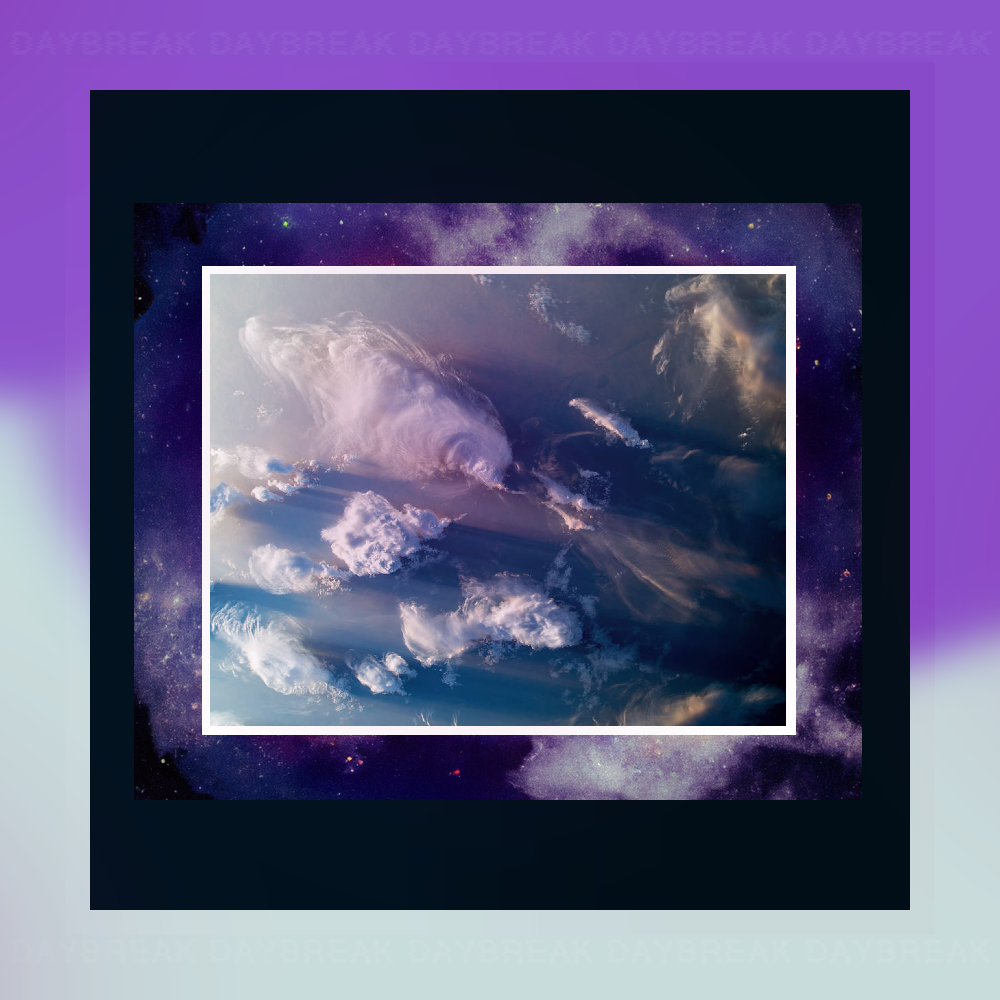

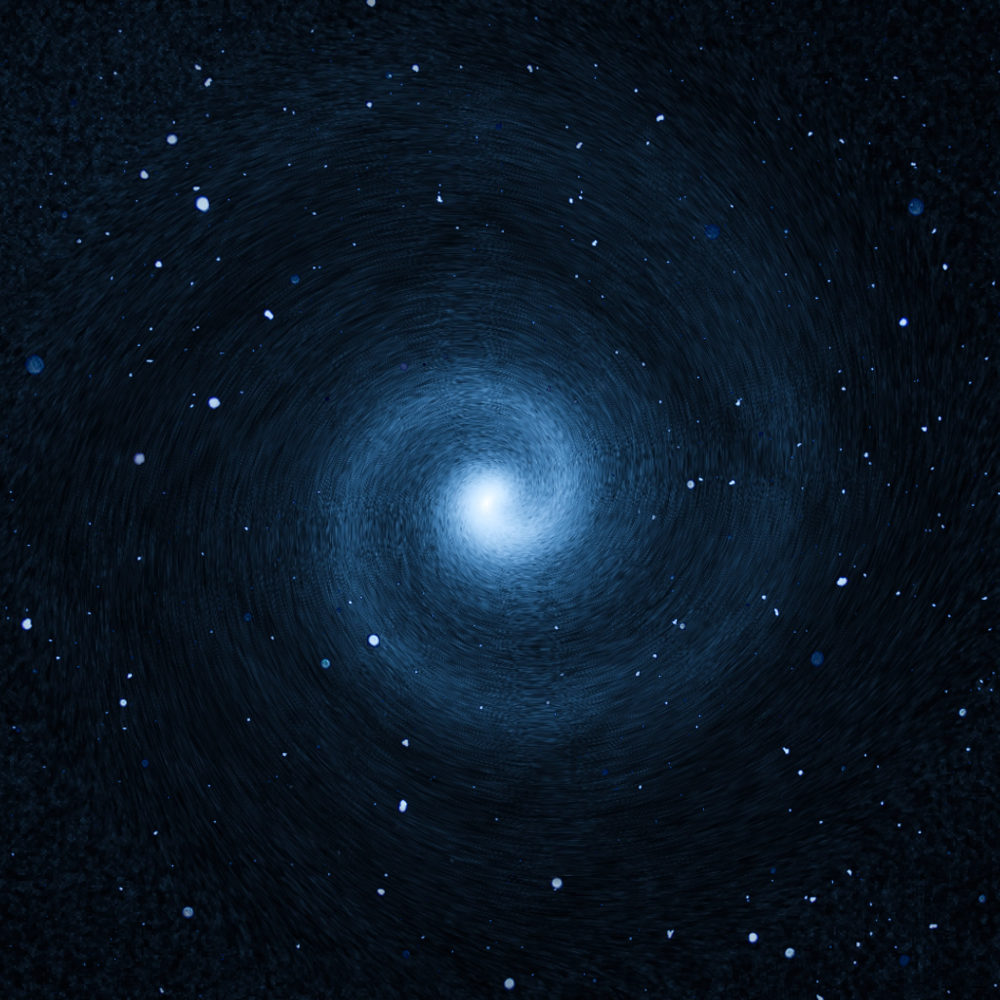

In [35]:

base_image = preprocess_image(from_image_path)
style_reference_image = preprocess_image(to_image_path)
combination_image = tf.Variable(preprocess_image(from_image_path))


display(Image(filename=from_image_path))
display(Image(filename=to_image_path))

Трансфер стилів:

C:\Users\Volodymyr\AppData\Roaming\Python\Python39\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_93']. Received: the structure of inputs=*
  warnings.warn(


Iteration 10: loss=11936.29
Iteration 20: loss=7759.83
Iteration 30: loss=5953.82
Iteration 40: loss=5099.24
Iteration 50: loss=4792.16
Iteration 60: loss=4047.90
Iteration 70: loss=3889.45
Iteration 80: loss=3458.99
Iteration 90: loss=3228.12
Iteration 100: loss=3076.42
Iteration 110: loss=2917.17
Iteration 120: loss=2762.50
Iteration 130: loss=2770.77
Iteration 140: loss=2554.39
Iteration 150: loss=2489.42
Iteration 160: loss=2387.02
Iteration 170: loss=2284.58
Iteration 180: loss=2340.56
Iteration 190: loss=2170.75
Iteration 200: loss=2155.44
Iteration 210: loss=2082.10
Iteration 220: loss=2014.35
Iteration 230: loss=1997.59
Iteration 240: loss=1921.49
Iteration 250: loss=1957.67
Iteration 260: loss=1867.71
Iteration 270: loss=1824.36
Iteration 280: loss=1813.35
Iteration 290: loss=1795.81
Iteration 300: loss=1733.55


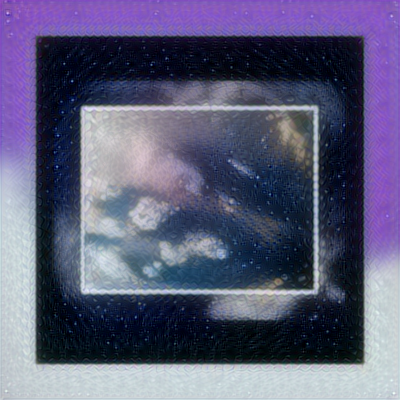

In [32]:
iterations = 300
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])

    # Print the loss at each iteration
    if i % 10 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))

# Save the final image after the loop is complete
img = deprocess_image(combination_image.numpy())  # Convert tensor to image format
fname = result_prefix + "_final.png"  # Create a filename for the final image
keras.utils.save_img(fname, img)  # Save the final image

Image(fname)  

Як бачимо стиль перенісся вдало, отримали основне зображення зі стилем іншого